## Obrada Point Cloud podataka - kodovi za projekat iz predmeta Digitalno procesiranje signala 

***

##### Instalacija biblioteka open3D i scikit-learn 

In [1]:
!pip install open3d

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


##### Import potrebnih biblioteka 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
import sys
import math
import random
from sklearn.cluster import MeanShift, estimate_bandwidth
from mpl_toolkits.mplot3d import Axes3D
import scipy  

##### Učitavamo Point Cloud podatke koje obrađujemo

In [40]:
PATH = "/home/hasti/DPS/PointCloudAlgorithms/ITC_groundfloor.ply"
pcd = o3d.io.read_point_cloud(PATH)

##### Centralizacija i vizualizacija učitanih podataka 

In [41]:
pcd_center = pcd.get_center()
pcd.translate(-pcd_center) # Transliramo point cloud tako da je njegovo središte u koordinatnom početku (0,0,0)
o3d.visualization.draw_geometries([pcd])

##### Voxel filtriranje 

In [42]:
voxel_size = 0.05
pcd_downsampled = pcd.voxel_down_sample(voxel_size=voxel_size)
o3d.visualization.draw_geometries([pcd_downsampled])

***

In [6]:
euclid = lambda x, y : math.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2 + (x[2] - y[2])**2 ) 

#### Statistical Outlier Removal 

In [18]:
nn = 16
std_multiplier = 5

filtered_pcd, filtered_idx = pcd.remove_statistical_outlier(nn, std_multiplier) # filtered_pcd ne sadrzi outliere

In [8]:
print(len(filtered_idx) / len(pcd.points)) # broj zadrzanih 

0.9945401681234178


In [9]:
outliers = pcd.select_by_index(filtered_idx, invert=True)
outliers.paint_uniform_color([1, 0, 0])
o3d.visualization.draw_geometries([filtered_pcd, outliers])

#### Radius Outlier Removal 

In [10]:
filtered_pcd, filtered_idx = pcd.remove_radius_outlier(nb_points=16, radius=0.5)

outliers = pcd.select_by_index(filtered_idx, invert=True)

In [12]:
print(len(filtered_idx) / len(pcd.points))

0.9999283564980657


In [35]:

outliers.paint_uniform_color([1, 0, 0])
o3d.visualization.draw_geometries([filtered_pcd, outliers])

#### Box Plot maksimalne udaljenosti tacaka do K-susjeda 

334992


{'whiskers': [<matplotlib.lines.Line2D at 0x745648daab90>,
 'caps': [<matplotlib.lines.Line2D at 0x745648dab0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x745648daa8f0>],
 'medians': [<matplotlib.lines.Line2D at 0x745648dab610>],
 'fliers': [<matplotlib.lines.Line2D at 0x745648dab8b0>],
 'means': []}

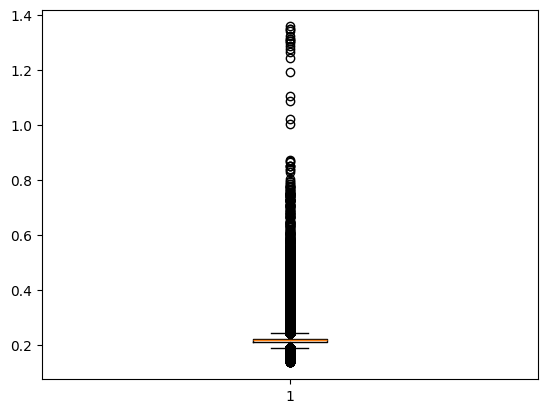

In [30]:
K = 50
pcd_tree = o3d.geometry.KDTreeFlann(pcd)
# Udaljenosti svaka tacka do 16-e najblize

dists_K = []
for p in range(0, len(pcd.points)):
    [k, idx, _] = pcd_tree.search_knn_vector_3d(pcd.points[p], K)
    #np.asarray(pcd.colors)[idx[1:], :] = [0, 0, 1]
    point = pcd.points[p]
    m = euclid(point, pcd.points[idx[-1]])
    dists_K.append(m)

print(len(dists_K))

plt.boxplot(dists_K)



***

#### Voxeling 

In [10]:
voxel_size = 0.25 
pcd_downsampled = filtered_pcd.voxel_down_sample(voxel_size = voxel_size)

In [11]:
o3d.visualization.draw_geometries([pcd_downsampled])

***

#### DBSCAN

***

#### K-means

In [79]:
class Cluster:
    def __init__(self, pts:list, data, metric=euclid):
        self.points = pts
        
        self.metric = metric
        self.data = np.asarray(data)
        self.centroid = self.compute_centroid()
    def update(self, pts:list):
        old_centroid = self.centroid
        self.points = pts
        self.centroid = self.compute_centroid()
        return self.metric(old_centroid, self.centroid)
    def compute_centroid(self):
        sum = np.array([0.0,0.0,0.0])
        for p in self.points:
            sum += self.data[p]
        return (sum[0] / len(self.points), sum[1] / len(self.points), sum[2] / len(self.points))
    def get_centroid(self):
        return self.centroid
    def get_points(self) -> list:
        return self.points
    def __iter__(self):
        return self.points.__iter__()
    def __next__(self):
        return self.points.__next__()
    def get_points(self):
        return self.points


        

In [77]:
def k_means(pcd, k):
    centroidi = random.sample(range(len(pcd.size)), k)
    clustering = []
    eps = 1e-6
    for c in centroidi:
        clustering.append(Cluster([c], pcd.points))
    converged = False
    num_itr = 0
    max_itr = 5
    while not converged and num_itr < max_itr:
        num_itr += 1
        new_clustering = []
        for i in range(k):
            new_clustering.append([])
        for p in range(len(pcd.points)):
            min = euclid(pcd.points[p], clustering[0].get_centroid())
            cluster_index = 0
            for i in range(1, k):
                d = euclid(pcd.points[p], clustering[i].get_centroid())
                if d < min:
                    min = d
                    cluster_index = i
            new_clustering[cluster_index].append(p)

        for group in new_clustering:
            if len(group) == 0:
                raise ValueError('Prazna grupa, nesretan pokusaj')
        converged = True
        for i in range(k):
            if clustering[i].update(new_clustering[i]) > eps:
                converged = False
        print(num_itr)
    return clustering

In [90]:
k = 37
uni_down_pcd = pcd.uniform_down_sample(every_k_points=10)
clustering = k_means(uni_down_pcd, k)





1
2
3
4
5


In [91]:
temp = []
for clus in clustering:
     t = uni_down_pcd.select_by_index(clus.get_points())
     t.paint_uniform_color([random.uniform(0.0,1.0) , random.uniform(0.0,1.0) , random.uniform(0.0,1.0)])
     temp.append(t)
o3d.visualization.draw_geometries(temp)


In [92]:
print(len(pcd.points))

334992


***

#### Mean shift

In [46]:
# Funkcije koje računanaju euklidsku udaljenost i implementiraju Gaussov kernel
def euclidean_distance(pointP, pointQ):
    total = float(0)
    for i in range(len(pointP)):
        total += (pointP[i] - pointQ[i])**2
    return math.sqrt(total)

def gaussian_kernel(distance, bandwidth):
    val = (1/(bandwidth*math.sqrt(2*math.pi))) * np.exp(-0.5*((distance / bandwidth))**2)
    return val

In [109]:
# Funkcije koje grupišu tačke u clustere nakon što su shift-ane 
GROUP_DISTANCE_TOLERANCE = 0.000001

class PointGrouper(object):
    def group_points(self, points):
        group_assignment = [] # lista koja čuva informacije kojoj od grupa pripada svaka tačka
        groups = []
        group_index = 0
        for point in points:
            nearest_group_index = self.determine_nearest_group(point, groups)
            if nearest_group_index is None:
                # tačka nije dovoljno blizu ni jednoj grupi da je možemo pridružiti u neku od njih, pa kreiramo novu grupu
                groups.append([point])
                group_assignment.append(group_index)
                group_index += 1
            else:
                group_assignment.append(nearest_group_index)
                groups[nearest_group_index].append(point)
        return np.array(group_assignment)

    def determine_nearest_group(self, point, groups):
        nearest_group_index = None
        index = 0 # brojač za grupe
        for group in groups: # iteriramo kroz postojeće grupe
            distance_to_group = self.distance_to_group(point, group)
            if distance_to_group < GROUP_DISTANCE_TOLERANCE:
                nearest_group_index = index # ako je tačka udaljena od najbliže grupe za GROUP_DISTANCE_TOLERANCE, pridružujemo je toj grupi
            index += 1
        return nearest_group_index

    def distance_to_group(self, point, group):
        min_distance = sys.float_info.max # najveća float vrijednost
        for pt in group:
            dist = euclidean_distance(point, pt)
            if dist < min_distance:
                min_distance = dist
        return min_distance # vraća najmanju udaljenost tačke od postojećih grupa

In [48]:
# Implementacija Mean-shift algoritma
MIN_DISTANCE = 0.000001

class MeanShift(object):
    def __init__(self, kernel=gaussian_kernel):
        self.kernel = kernel

    def cluster(self, points, kernel_bandwidth):
        points = np.array(points, dtype=float) # pretvaramo podatke u nparray za numeričku obradu

        # kreiramo kopiju podataka kako bismo pomijerali tačke point cloud-a bez da mijenjamo stvarne podatke 
        shift_points = np.array(points) # kada se algoritam završi, shift_points sadrži finalne pozicije svih tačaka, što predstavlja centre pronađenih clustera 
        
        distance = 1 # pomoćna varijabla za čuvanje udaljenosti između tačaka pri traženju središta clustera
        counter = 0 # brojač iteracija
        still_shifting = [True] * points.shape[0] # niz bool-ova pomoću kojeg pamtimo koje tačke su već konvergirale u neki od centara clustera
        
        while distance > MIN_DISTANCE: # dok ne pronađemo sve clustere
            distance = 0
            counter += 1
            for i in range(0, len(shift_points)): # obrađujemo sve tačke -> ako se svaka tacka shiftala za manje od MIN_DISTANCE, znači da je svaka konvergirala u centar svog clustera
                if not still_shifting[i]: # preskačemo tačku koja je već konvergirala
                    continue
                p_new = shift_points[i]
                p_new_start = p_new # pamtimo početnu poziciju tačke
                p_new = self.shift_point(p_new, points, kernel_bandwidth) # shift-amo tačku ka centru njenog clustera
                dist = euclidean_distance(p_new, p_new_start) # računamo udaljenost njene stare i nove pozicije
                if dist > distance: 
                    distance = dist
                if dist < MIN_DISTANCE:
                    still_shifting[i] = False # tačka je konvergirala 
                shift_points[i] = p_new # bilježimo novu poziciju obrađene tačke
        point_grouper = PointGrouper()
        group_assignments = point_grouper.group_points(shift_points.tolist())
        return MeanShiftResult(points, shift_points, group_assignments)

    def shift_point(self, point, points, kernel_bandwidth):
        points = np.array(points)

        shift_x = float(0)
        shift_y = float(0)
        shift_z = float(0)
        scale_factor = float(0)
        for p in points:
            dist = euclidean_distance(point, p) 
            weight = self.kernel(dist, kernel_bandwidth) # računamo "težinski faktor" svake tačke u point cloudu na osnovu njihove udaljenosti od trenutne. Gaussian filter će ove vrijednosti skalirati tako da što su tačke bliže promatranoj, njihov težinski faktor je veći
            # množimo koordinate svake tačke sa njenim težinskim faktorom i sumiramo ih da bismo dobili koordinate na koje trebamo shiftati posmatranu tačku
            shift_x += p[0] * weight
            shift_y += p[1] * weight
            shift_z += p[2] * weight
            scale_factor += weight # sumiramo težinske faktore
        # normaliziramo izračunate nove koordinate
        shift_x = shift_x / scale_factor
        shift_y = shift_y / scale_factor
        shift_z = shift_z / scale_factor
        return [shift_x, shift_y, shift_z]

class MeanShiftResult:
    def __init__(self, original_points, shifted_points, cluster_ids):
        self.original_points = original_points
        self.shifted_points = shifted_points
        self.cluster_ids = cluster_ids

In [62]:
retained_ratio = 0.003
pcdh = pcd.random_down_sample(retained_ratio)
mean_shift = MeanShift()
mean_shift_result = mean_shift.cluster(np.asarray(pcdh.points), kernel_bandwidth=2)

for i in range(len(mean_shift_result.shifted_points)):
    original_point = mean_shift_result.original_points[i]
    converged_point = mean_shift_result.shifted_points[i]
    cluster_assignment = mean_shift_result.cluster_ids[i]

Original Point     Shifted Point  Cluster ID


##### Vizualizacija

In [ ]:
unique_labels = np.unique(mean_shift_result.cluster_ids)
colormap = plt.get_cmap('tab10')  
colors = colormap(np.linspace(0, 1, len(unique_labels)))[:, :3]  
print(mean_shift_result.cluster_ids)

label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
point_colors = np.array([label_to_color[label] for label in mean_shift_result.cluster_ids])

point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(mean_shift_result.original_points)
point_cloud.colors = o3d.utility.Vector3dVector(point_colors)

o3d.visualization.draw_geometries([point_cloud])

##### Upotreba bibliotečne funkcije Mean shift

In [111]:
mns = o3d.geometry.PointCloud(pcd)
pnts = np.asarray(mns.points)

ms = MeanShift(bandwidth=0.45, bin_seeding=True)
ms.fit(pnts)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

In [113]:
n_clusters_ = len(np.unique(labels))
colors = plt.cm.Spectral(np.linspace(0,1,n_clusters_))[:,:3]
point_colors = np.array([colors[label] for label in labels])
mns.colors = o3d.utility.Vector3dVector(point_colors)

o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


***

#### DBSCAN nad manjim 2d datasetom

In [47]:
def next_id(cluster_id):
    return cluster_id + 1

UNCLASSIFIED = -1
NOISE = 0
import math
def metric(x, y):
    return math.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

def region_query(pcd, i, eps):

    p = i
    s = set()
    for point in pcd:
        r = metric(p, point)
        if  r <= eps and r > 0:
            s.add(point)
  
  
    return s

def expand_cluster(point_cloud, labels, i, cluster_id, eps, minPts):
 
    labels[cluster_id] = set()
    labels[cluster_id].add(point_cloud[i]) 
    seed = region_query(point_cloud, point_cloud[i], eps)
    if len(seed) < minPts:
        labels[NOISE].add(point_cloud[i])

        return False
    for p in seed:
        labels[cluster_id].add(p)

    while len(seed) != 0:
        curr = seed.pop()
        result = region_query(point_cloud, curr, eps)
        if len(result) >= minPts:
            for k in result:
                if k in labels[NOISE]:
                    if k not in labels.items():
                        seed.add(k)
                    # unija svih
                    labels[cluster_id].add(k)
 

    return True


def dbscan(point_cloud, eps, minPts):
    cluster_id = next_id(NOISE)
    labels = {}
    labels[NOISE] = set()
    labeled = set()
    for i in range(0, len(point_cloud)):
        if point_cloud[i] in labeled:
            continue
        labeled.add(point_cloud[i])

        if expand_cluster(point_cloud, labels, i, cluster_id, eps, minPts):
            cluster_id = next_id(cluster_id)

    return labels


In [48]:
df = pd.read_csv('/home/hasti/DPS/resursi/outliers.csv')
df = df[['x', 'y']]

c = df.to_numpy()
cloud = tuple(map(tuple, c))

In [49]:
C = dbscan(cloud, 15, 4)
for item in C.items():
    if len(item) == 0:
        print(len(item))

/tmp/ipykernel_4263/1162005762.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y, c = (random.random(), random.random(), random.random()), s = 10)


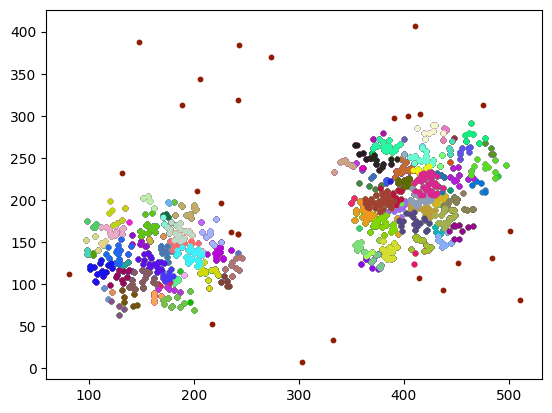

In [50]:

for i in C.keys():
    v = list(C[i])    
    x, y = zip(*v)
    plt.scatter(x,y, c = (random.random(), random.random(), random.random()), s = 10)

plt.show()

#### DBSCAN

In [45]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd.cluster_dbscan(eps=0.1025, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

[Open3D DEBUG] Precompute neighbors.
Precompute neighbors.[========================================] 100%
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
Clustering[==================>    [Open3D DEBUG] Done Compute Clusters: 28
point cloud has 28 clusters=======================>] 97%


#### Procjena DBSCAN argumenata

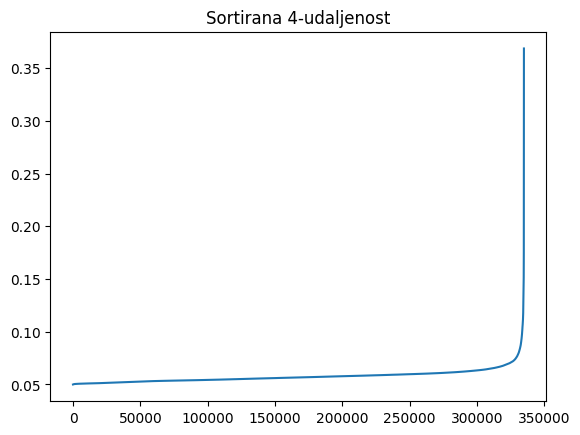

In [46]:
pcd_tree = o3d.geometry.KDTreeFlann(pcd)

dists = []

for i in range(len(pcd.points)):
    [k, idx, _] = pcd_tree.search_knn_vector_3d(pcd.points[i], 4)
    dists.append(euclid(pcd.points[i], pcd.points[idx[-1]]))

dists.sort()

plt.plot(dists)
plt.title('Sortirana 4-udaljenost')
plt.show()

In [37]:
import scipy.integrate
import scipy.interpolate
import scipy.optimize


size = len(pcd.points)

x = np.arange(size)
spline = scipy.interpolate.CubicSpline(x, dists)

f = np.polynomial.chebyshev.Chebyshev.fit(x, dists, 4)

d1 = f.deriv()
d2 = d1.deriv()

df = lambda x : d1(x)
d2f = lambda x : d2(x)

curvature = lambda x: abs(d2f(x)) / (1 + df(x)**2)**1.5

max_x = scipy.optimize.minimize(lambda x: -curvature(x), size * 0.85, bounds=[(0.0,size)])

epsilon = f(max_x.x[0])
print('epsilon procjenjeni je ', epsilon)
print(max_x.x)

epsilon procjenjeni je  0.06207727858028317
[284743.2]


In [38]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd.cluster_dbscan(eps=epsilon, min_points=4, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

[Open3D DEBUG] Precompute neighbors.
Precompute neighbors.[========================================] 100%
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1291=======> ] 95%
point cloud has 1291 clusters


***

#### RANSAC 

In [73]:
class RANSAC:
    def __init__(self, point_cloud, max_iterations, distance_ratio_threshold):
        self.point_cloud = point_cloud
        self.max_iterations = max_iterations
        self.distance_ratio_threshold = distance_ratio_threshold

    def run(self):
        # Metoda pronalazi inliere i outliere ravni sa najvise inliera i vizualizira ih korištenjem Open3D biblioteke
        inliers, outliers, best_plane = self._ransac_algorithm(self.max_iterations, self.distance_ratio_threshold)

        # Kreiramo Open3D Point Cloud objekat za inliere najbolje ravni
        pcdin = o3d.geometry.PointCloud()
        pcdin.points = o3d.utility.Vector3dVector(inliers)

        # Kreiramo Open3D Point Cloud objekat za outliere najbolje ravni
        pcdout = o3d.geometry.PointCloud()
        pcdout.points = o3d.utility.Vector3dVector(outliers)

        # Bojimo inliere crveno, a outliere sivo
        pcdin.paint_uniform_color([1.0, 0, 0])
        pcdout.paint_uniform_color([0.6, 0.6, 0.6])
        
        # Vizualiziramo inliere i outliere
        o3d.visualization.draw_geometries([pcdin, pcdout])

        return inliers, best_plane

    def _ransac_algorithm(self, max_iterations, distance_ratio_threshold):
        # Implementacija RANSAC algoritma
        best_inliers_result = []
        best_plane = None
        points = np.asarray(self.point_cloud.points)
        num_points = points.shape[0]

        while max_iterations:
            max_iterations -= 1
            # Biramo tri nasumične tačke iz Point Cloud podatka
            inliers = random.sample(range(num_points), 3)
            x1, y1, z1 = points[inliers[0]]
            x2, y2, z2 = points[inliers[1]]
            x3, y3, z3 = points[inliers[2]]

            # Jednačina ravni -> ax + by + cz + d = 0
            # Izračun koeficijenata ravni 
            a = (y2 - y1)*(z3 - z1) - (z2 - z1)*(y3 - y1)
            b = (z2 - z1)*(x3 - x1) - (x2 - x1)*(z3 - z1)
            c = (x2 - x1)*(y3 - y1) - (y2 - y1)*(x3 - x1)
            d = -(a*x1 + b*y1 + c*z1)
            plane_length = max(0.1, math.sqrt(a*a + b*b + c*c))

            # U skupinu inlier-a za trenutnu ravan dodajemo sve tacke čija je udaljenost od ravni manja treshold-a
            current_inliers = inliers.copy()
            for idx, (x, y, z) in enumerate(points):
                # Ako je trenutna tačka jedna od početne tri, preskačemo je
                if idx in inliers:
                    continue

                # Izračunavamo udaljenost trenutne tačke od ravni 
                distance = math.fabs(a*x + b*y + c*z + d) / plane_length
                # Ako je ta udaljenost manja ili jednaka distance_ratio_treshold, dodajemo je u skupinu inliera
                if distance <= distance_ratio_threshold:
                    current_inliers.append(idx)

            # Ako trenutna ravan ima više inliera od svi dosad ispitanih ravni, pohranjujemo je u best_plane
            if len(current_inliers) > len(best_inliers_result):
                best_inliers_result = current_inliers
                best_plane = (a, b, c, d)

        # Izdvajamo inliere i outliere od best_plane (ravan sa najviše inliera od ispitanih) iz Point Cloud podatka 
        inlier_points = points[best_inliers_result]
        outlier_points = np.delete(points, best_inliers_result, axis=0)

        # Iz funkcije vraćamo inliere, outliere ravni sa najviše inliera i tu ravan        
        return inlier_points, outlier_points, best_plane

In [74]:
distance_threshold = 0.1
num_iterations = 100

In [75]:
APPLICATION = RANSAC(pcd, max_iterations=num_iterations, distance_ratio_threshold=distance_threshold)
inliers, plane_model = APPLICATION.run()
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

Plane equation: 0.00x + -0.00y + 8.90z + 12.07 = 0


#### Multi-order RANSAC

In [76]:
segment_models={}
segments={}

In [77]:
max_plane_idx=10

In [78]:
epsilon = 0.15
min_cluster_points = 5

In [83]:
rest = pcd
for i in range(max_plane_idx):
    segment_models[i], inliers = rest.segment_plane(distance_threshold=0.1,ransac_n=3,num_iterations=1000)
    segments[i] = rest.select_by_index(inliers) # izdvajamo inliere za trenutni plane
    # dbscan unutar iteracije ransaca da izdvojimo najveci cluster u segmentu
    labels = np.array(segments[i].cluster_dbscan(eps=epsilon, min_points=min_cluster_points)) # dbscan nad izdvojenim segmentom
    candidates=[len(np.where(labels==j)[0]) for j in np.unique(labels)] # izdvajamo clustere
    best_candidate_index = np.argmax(candidates) # od clustera u trenutnom segmentu izdvajamo najveci
    best_candidate = int(np.unique(labels)[best_candidate_index])
    rest = rest.select_by_index(inliers, invert=True) + segments[i].select_by_index(list(np.where(labels!=best_candidate)[0])) # iz ransac iteracije u rest vracamo sve tacke koje nisu u najvecem clusteru
    segments[i]=segments[i].select_by_index(list(np.where(labels== best_candidate)[0])) # u segment[i] stavljamo samo tacke najveceg clustera
    
    colors = plt.get_cmap("tab20")(i)
    segments[i].paint_uniform_color(list(colors[:3]))
    print("pass",i,"/",max_plane_idx,"done.")

pass 0 / 10 done.
pass 1 / 10 done.
pass 2 / 10 done.
pass 3 / 10 done.
pass 4 / 10 done.
pass 5 / 10 done.
pass 6 / 10 done.
pass 7 / 10 done.
pass 8 / 10 done.
pass 9 / 10 done.


In [84]:
o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)]+[rest])

In [85]:
o3d.visualization.draw_geometries([rest]) # tacke koje nisu ni u jednom segmentu -> moramo nad njima detaljniji dbscan

#### DBSCAN nad neklasificiranim tačkama

In [86]:
labels = np.array(rest.cluster_dbscan(eps=0.26, min_points=20))
print(len(np.unique(labels))) # broj identifikovanih clustera + outlieri

34


In [87]:
max_label = labels.max()
colors = plt.get_cmap("tab10")(labels)
colors[labels < 0] = 1
rest.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([rest])

In [88]:
o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)]+[rest]) # vizualizacija svega

***